# La nueva normalidad del crimen en la CDMX

El propósito de este artículo es visualizar los cambios en incidencia delictiva a raíz de la pandemia de COVID-19.
Para ello, usaremos los datos de las carpetas de invertigacion de la PGJ de la CDMX, así como mapas a nivel AGEB y delegación.

Contenido:
- Lectura y limpieza
- Evolución temporal agregada
- Cambios por delegación
- Cambios en los focos rojos de la ciudad

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
import descartes
import math

from datetime import datetime
from collections import Counter

from sklearn.cluster import DBSCAN

## Lectura y limpieza

In [2]:
datos = pd.read_csv('inputs/carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico.csv')
datos.head()

ao_hechos mes_hechos         fecha_hechos  \
0     2017.0    Octubre  2017-10-06 12:00:00   
1     2017.0  Noviembre  2017-11-15 20:00:00   
2     2017.0  Noviembre  2017-11-15 18:30:00   
3     2017.0  Noviembre  2017-11-15 17:32:00   
4     2017.0  Noviembre  2017-11-14 19:00:00   

                                       delito  \
0                                      FRAUDE   
1         PERDIDA DE LA VIDA POR OTRAS CAUSAS   
2  ROBO A TRANSEUNTE DE CELULAR CON VIOLENCIA   
3           ROBO DE MOTOCICLETA CON VIOLENCIA   
4        ROBO A CASA HABITACION SIN VIOLENCIA   

                       categoria_delito                         fiscalia  \
0                DELITO DE BAJO IMPACTO    INVESTIGACIÓN EN AZCAPOTZALCO   
1                    HECHO NO DELICTIVO         INVESTIGACIÓN EN TLALPAN   
2                DELITO DE BAJO IMPACTO      INVESTIGACIÓN EN IZTAPALAPA   
3  ROBO DE VEHÍCULO CON Y SIN VIOLENCIA  INVESTIGACIÓN EN MIGUEL HIDALGO   
4                DELITO DE BAJO IMPACTO      INVESTIGACIÓN EN IZTAPALAPA   

  agencia unidad_investigacion alcaldia_hechos  \
0    AZ-1               UI-3SD      IZTAPALAPA   
1   TLP-2               UI-3CD         TLALPAN   
2   IZP-4               UI-3SD      IZTAPALAPA   
3    MH-2               UI-1SD  MIGUEL HIDALGO   
4   IZP-9               UI-3SD      IZTAPALAPA   

                         colonia_hechos  ao_inicio mes_inicio  \
0                              APATLACO       2017  Noviembre   
1             MIGUEL HIDALGO 2A SECCIÓN       2017  Noviembre   
2              DR. ALFONSO ORTIZ TIRADO       2017  Noviembre   
3                     LOMAS DE SOTELO I       2017  Noviembre   
4  2A. AMPLIACIÓN SANTIAGO ACAHUALTEPEC       2017  Noviembre   

          fecha_inicio              calle_hechos  calle_hechos2   longitud  \
0  2017-11-15 20:14:33            REAL DEL MONTE            NaN -99.116256   
1  2017-11-15 20:15:06             JESUS LECUONA         OAXACA -99.193514   
2  2017-11-15 20:18:33        SAN RAFAEL ATLIXCO            NaN -99.073700   
3  2017-11-15 20:19:27  AV. INGENIEROS MILITARES            NaN -99.217985   
4  2017-11-15 20:20:20                EVA SAMANO  LEONA VICARIO -99.012944   

     latitud                      geopoint  
0  19.380585  19.3805845107,-99.1162559436  
1  19.286033  19.2860327788,-99.1935140733  
2  19.387269  19.3872690138,-99.0736999107  
3  19.453354  19.4533537449,-99.2179851004  
4  19.347705   19.3477045484,-99.012944086

Para revisar la calidad de estos datos, revisaremos lo siguiente:

- La unicidad por categoría: si los registros fueron hechos a mano se presta a que haya más de un registro por faltas de ortografía (por ejemplo, COYOACAN y COYOACÁN)

- La cantidad de datos por categoría: se observa información hasta 1901, pero es probable que solo sea un hecho histórico registrado para ese año y no se tengan registros para años intermedios. Dado que tras observar la serie de tiempo se nota un incremento sustancial exactamente al iniciar 2016, lo cual se debe deber a un tema de registros, sólo consrvaremos la información disponible a partir de ese momento.

- Convertimos las fechas a formato fecha. Para los valores faltantes tomamos la fecha de la variable fecha_inicio

- Sólo conservamos datos de delitos ocurridos en la CDMX

In [3]:
# limpieza general

################################################################################

# solo conservamos registros de las top 16 alcaldias, que son las delegaciones, pues el resto son alcaldias menores del area metropolitana

ranking_delitos_alcaldia=datos[['alcaldia_hechos','delito']]\
    .groupby('alcaldia_hechos').count()\
    .reset_index()\
    .sort_values(by='delito',ascending=False)

datos=datos[ datos['alcaldia_hechos'].isin( ranking_delitos_alcaldia.loc[:16,'alcaldia_hechos'] ) ]\
    .reset_index().drop(columns='index')

del ranking_delitos_alcaldia

################################################################################

# limpiamos las fechas

datos['fecha']=datetime.strptime('2000-12-31 10:10','%Y-%m-%d %H:%M').date()
datos['aux']=datos['fecha_hechos'].apply(lambda x: str(x)[2])

aux_num=list(map(str,range(10)))

datos.loc[datos['aux'].isin(aux_num),'fecha']=datos.loc[datos['aux'].isin(aux_num),'fecha_hechos']\
    .apply(lambda x: str(x)[:16])\
    .str.replace('/','-').str.replace('T',' ')\
    .apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M').date())

del aux_num

##########################

#n, se reemplazan por fecha_inicio que fluye sin problema
datos.loc[datos['aux']=='n','fecha']=datos.loc[datos['aux']=='n','fecha_inicio']\
    .apply(lambda x: str(x)[:16])\
    .str.replace('/','-').str.replace('T',' ')\
    .apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M').date())

#/, solo tienen un formato de prsentación distinto
datos.loc[datos['aux']=='/','fecha']=datos.loc[datos['aux']=='/','fecha_hechos']\
    .apply(lambda x: str(x)[:16])\
    .str.replace('/','-').str.replace('T',' ')\
    .apply(lambda x: datetime.strptime(x,'%d-%m-%Y %H:%M').date())

datos.loc[datos['aux']==' ','auxx']=datos.loc[datos['aux']==' ','fecha_inicio']\
    .apply(lambda x: str(x)[2])

##########################

datos.loc[datos['auxx'].isin(['/','-']),'fecha']=datos.loc[datos['auxx'].isin(['/','-']),'fecha_inicio']\
    .apply(lambda x: str(x)[:16]).str.replace('/','-').str.replace('T',' ')\
    .apply(lambda x: datetime.strptime(x,'%d-%m-%Y %H:%M').date())

aux_num=list(map(str,range(10)))

datos.loc[datos['auxx'].isin(aux_num),'fecha']=datos.loc[datos['auxx'].isin(aux_num),'fecha_inicio']\
    .apply(lambda x: str(x)[:16]).str.replace('/','-').str.replace('T',' ')\
    .apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M').date())

del aux_num

datos=datos.drop(columns=['aux','auxx'])

################################################################################

# unicamente conservamos datos a partir de 2016

datos=datos[datos['fecha']>=datetime.strptime('01-01-2016','%d-%m-%Y').date()]

# generamos variables de mes_ano y semana

datos['mes_ano']=datos['fecha'].apply(lambda x: datetime.strptime((str(x.year))+'-'+str(x.month)+'-01','%Y-%m-%d').date())

datos['semana']=datos['fecha'].apply(lambda x: x.strftime("%U"))

## Evolución temporal agregada

Se propone comparar la incidencia de diferentes tipos de delitos antes y después de la llegada de la pandemia. Para ello, primero debemos determinar los conjuntos de información elegidos para cada período.

Para el período con COVID es bastante simple, pues sólo tenemos que ubicar el momento a partir del cuál la gente comenzó su confinamiento. Los datos muestran de manera clara la fecha en la que esto ocurrió: Abril.
Casi todos los delitos disminuyen durante la primera mitad del año, debido a los efectos de la pandemia. Su posterior crecimiento y en algunos casos estabilización podrían considerarse como la "nueva normalidad".

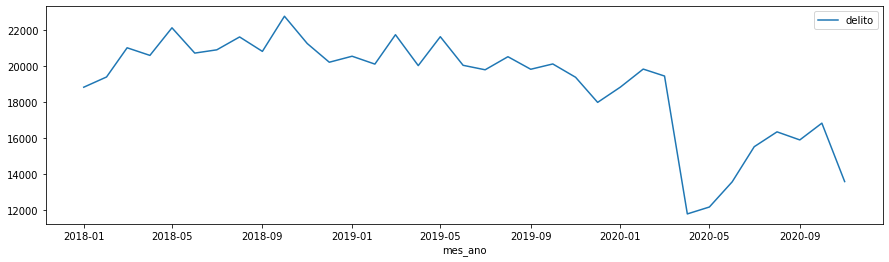

In [4]:
datos.loc[ (datos['fecha']>datetime.strptime('01-01-2018','%d-%m-%Y').date()) & 
          (datos['fecha']<datetime.strptime('01-01-2021','%d-%m-%Y').date()),
          ['mes_ano','delito']]\
    .groupby('mes_ano')\
    .count()\
    .plot(figsize=(15,4));

Para la determinación del período pre-COVID, lo más sencillo sería mantener todas las observaciones anteriores. Sin embargo, a pesar de que la información observada no muestra un choque releveante en la incidencia delictiva, han ocurrido cambios estructurales que obligan a hacer una exploración adicional.

En particular, valdría la pena buscar por cambios en patrones a raíz de la llegada de Claudia Sheinbaum a la jefatura de gobierno.

Desglosando los casos por tipo de delito podemos observar grandes cambios en sus respectivas categorías a lo largo del tiempo. Esto se puede deber a cambios en la estrategia de seguridad del gobierno, pero los cambios más grandes probablemente se deban a cambios en las tipificaciones de los delitos.

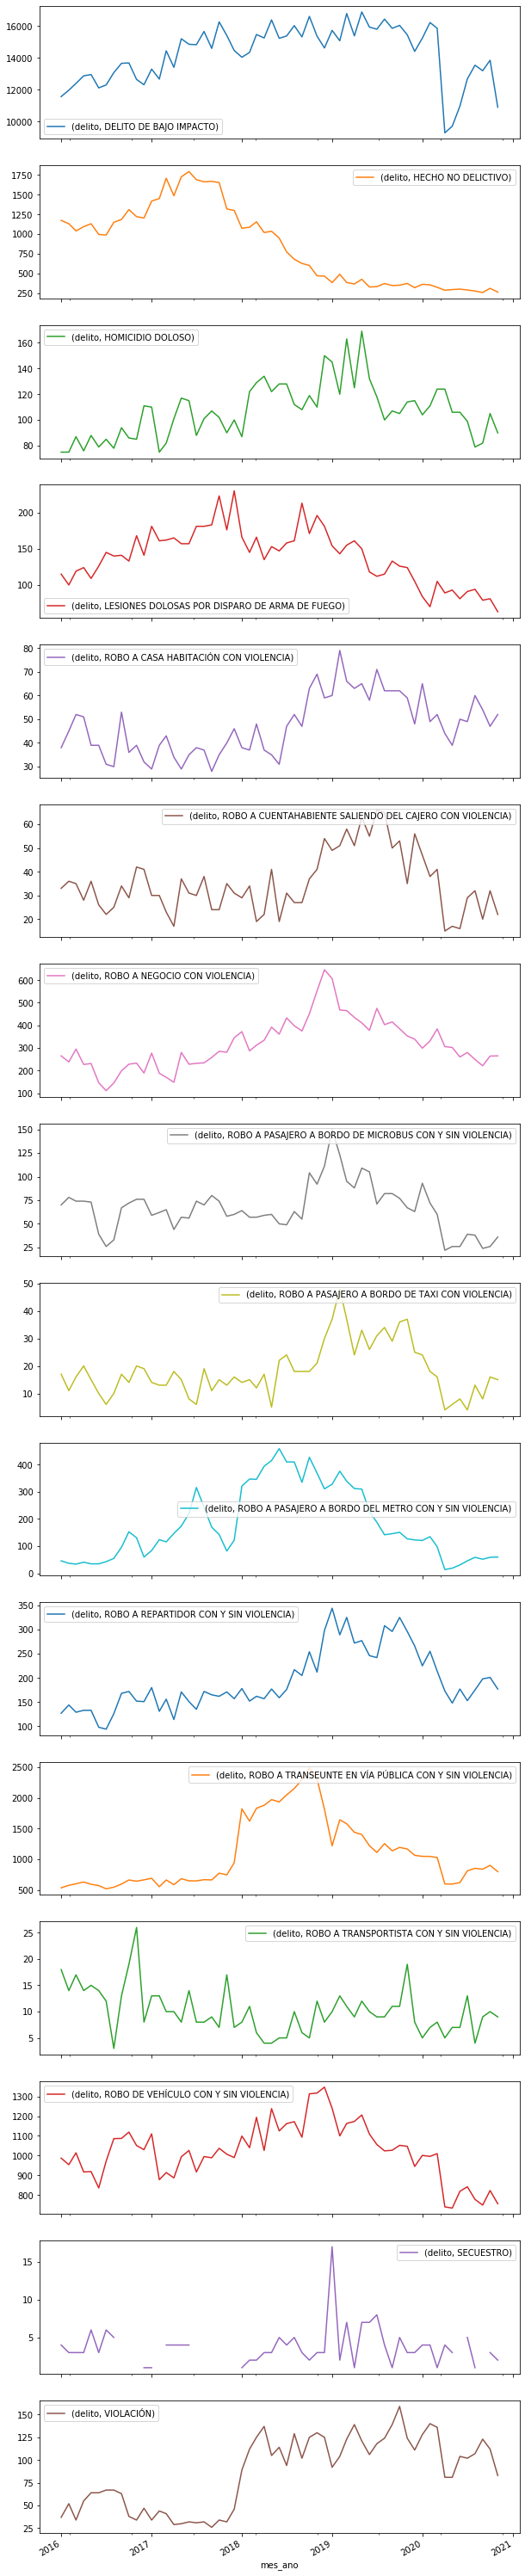

In [5]:
#datos.loc[datos['mes_ano']>=datetime.strptime('01-01-2020','%d-%m-%Y').date(),['mes_ano','categoria_delito','delito']]\
datos.loc[:,['mes_ano','categoria_delito','delito']]\
    .groupby(['mes_ano', 'categoria_delito'])\
    .count()\
    .unstack()\
    .plot(subplots=True,figsize=(10,60));

En la mayoría de los casos podemos observar cierta estabilidad, o al menos una tendencia sin grandes cambios, en el período a partir del cual llega Sheinbaum. Tomando en consideración posibles choques temporales derivados de la transición de gobierno, tomaremos la información 3 meses después de la toma de posesión de Sheinbaum, es decir, a aprtir de febrero de 2019.

In [6]:
datos=datos[datos['fecha']>=datetime.strptime('01-02-2019','%d-%m-%Y').date()].reset_index()

Con esta muestra reducida, vemos las correlaciones entre los distintos delitos, que sugieren algunas cosas:
- Los delitos de bajo impacto y hechos no delictivos están altamente correlacionados. Es posible que las caracteristicas de ambos tipos sean muy similares y, como consecuencia, frecuentemente delitos similares sean clasificados de manera arbitraria en una u otra de las categorías.
- Curiosamente, el robo a pasajero a bordo de taxi está poco correlacionado con el robo en microbus. Nótese que no es lo mismo a correlación negativa, que de ser el caso uno argumentaría que son sustitutos en cada región.

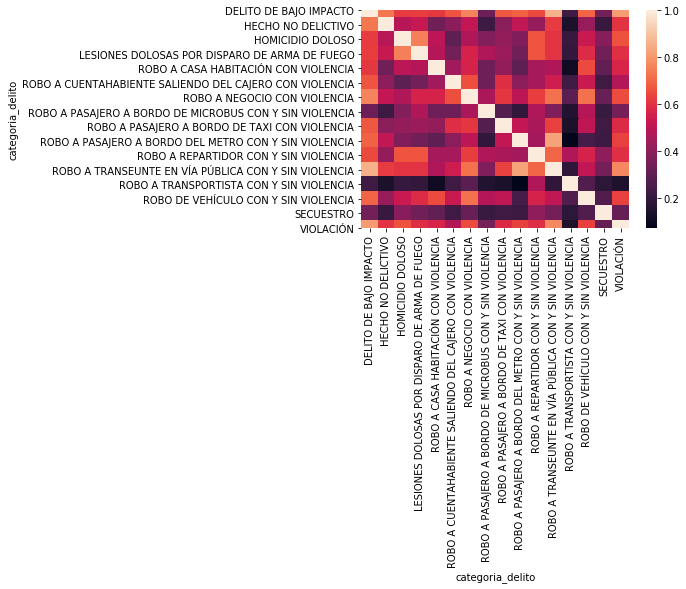

In [7]:
delitos_por_colonia=datos[['categoria_delito','delito','colonia_hechos']]\
    .groupby(['categoria_delito','colonia_hechos'])\
    .count().reset_index()\
    .pivot(index='colonia_hechos',columns='categoria_delito',values='delito')\
    .fillna(0)

sns.heatmap(delitos_por_colonia.corr())

plt.show()

del delitos_por_colonia

Como análisis posterior se considera hacer pruebas de Perron de cambios de tendencia de series de tiempo.

## Cambios por delegación

Ahora, pasaremos a ver el cambio en incidencia delictiva per capita de cada tipo de crimen por delegación.

Se tomó la base de Indicadores de Peligro, Exposición y Vulnerabilidad a nivel AGEB del Atlas de Riesgo de la ciudad, con datos de población de 2010 (http://www.atlas.cdmx.gob.mx/datosabiertos.html). Posteriormente, se agregó la información al nivel de delegación, con una mapa de municipalidades de CONABIO (http://www.conabio.gob.mx/informacion/metadata/gis/muni_2018gw.xml?_httpcache%20=%20yes&_xsl=/db/metadata/xsl/fgdc_html.xsl&_indent%20=%20no) para el que conservamos únicamente el terriotorio correspondiente a la CDMX.

Para compararlos, **tomaremos el mismo periodo de tiempo para cada año**. Basándonos en los datos observados durante la pandemia, conservaremos la información de junio a noviembre, puesto que a partir de junio se "recuperó" la incidencia delictiva en la ciudad. De manera análoga, conservaremos los mismos meses para 2019 y los tomaremos como el periodo anterior.

In [8]:
#Por desgracia los datos de población no son muy estables, por lo que descartamos las AGEBs con menos de 600 habitantes para quitar observaciones sin información y con poca gente que tienen mucha varianza. Esto representa menos del 7% de las AGEBs, por lo que se conserva una parte sustancial del mapa.
datos['Periodo']='ninguno'

datos.loc[(datos['fecha']>=datetime.strptime('01-06-2019','%d-%m-%Y').date()) & 
          (datos['fecha']<datetime.strptime('01-12-2019','%d-%m-%Y').date()),'Periodo']='Pre'

datos.loc[(datos['fecha']>=datetime.strptime('01-06-2020','%d-%m-%Y').date()) & 
          (datos['fecha']<datetime.strptime('01-12-2020','%d-%m-%Y').date()),'Periodo']='Post'

datos=datos[datos['Periodo']!='ninguno']

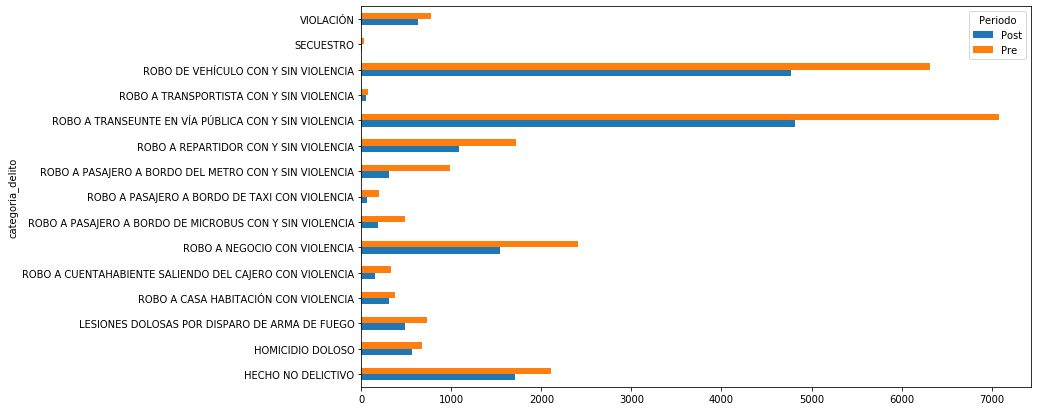

In [9]:
datos_periodos=datos[['delito','categoria_delito','Periodo']].groupby(['categoria_delito','Periodo']).count().reset_index()

datos_periodos[datos_periodos['categoria_delito']!='DELITO DE BAJO IMPACTO']\
    .pivot("categoria_delito", "Periodo", "delito")\
    .plot(kind='barh',figsize=(12,7))

plt.show()

In [10]:
mapa = gpd.read_file("inputs/mapa_cdmx_ageb")
mapa['CVE_ALCALDIA']=mapa['CVEGEO'].str.slice(0,5)
mapa.head()

ID           ENTIDAD       ALCALDIA         CVEGEO        AREA_M2  \
0  1.0  Ciudad de México     Xochimilco  0901300010495   53528.760180   
1  2.0  Ciudad de México     Xochimilco  0901300011455  581474.697123   
2  3.0  Ciudad de México     Xochimilco  0901300011402  284427.610820   
3  4.0  Ciudad de México     Xochimilco  0901300011120  193874.809681   
4  5.0  Ciudad de México  Benito Juárez  0901400010168  123522.838236   

      PERIME_M  VIV_TOT  ESCUELAS  HOSPITALES  BANCOS     ...        TEM_MIN  \
0  1358.546344    166.0       4.0         0.0     0.0     ...       Muy Bajo   
1  4118.348988    428.0       0.0         0.0     0.0     ...       Muy Bajo   
2  2494.075659    746.0       0.0         0.0     0.0     ...           Bajo   
3  1969.924742    633.0       0.0         0.0     0.0     ...       Muy Bajo   
4  1794.429537    617.0       6.0         0.0     3.0     ...       Muy Bajo   

      INT_NUM__1    NEVADA  INT_NUM_NE  SUS_LADERA  VUL_SOCIAL  VUL_SOC_FR  \
0    0.3 a -1.87  Muy Bajo       0 a 9        Alto       Medio       Medio   
1    0.3 a -1.87  Muy Bajo       0 a 9        Bajo         N/D    Muy Alto   
2  -1.87 a -2.38  Muy Bajo       0 a 9    Muy Bajo    Muy Alto    Muy Alto   
3    0.3 a -1.87  Muy Bajo       0 a 9    Muy Bajo        Alto       Medio   
4    0.3 a -1.87  Muy Bajo       0 a 9    Muy Bajo    Muy Bajo        Bajo   

      SISMO                                           geometry CVE_ALCALDIA  
0     Medio  POLYGON ((-99.11117361594765 19.24416288344887...        09013  
1     Medio  POLYGON ((-99.13599180249706 19.23897446359112...        09013  
2      Alto  POLYGON ((-99.07999500821587 19.25785093884435...        09013  
3  Muy Alto  POLYGON ((-99.09677412335641 19.25855872322206...        09013  
4  Muy Alto  POLYGON ((-99.13396821272482 19.39274907781546...        09014  

[5 rows x 37 columns]

In [11]:
mapa_del = gpd.read_file("inputs/mapa_cdmx_del")
mapa_del = mapa_del[mapa_del['CVE_ENT']=='09']
mapa_del.head()

CVE_ENT CVE_MUN CVEGEO            NOM_ENT        AREA  PERIMETER  \
270      09     002  09002  Ciudad de MÃ©xico  3332.30920   33.32309   
271      09     003  09003  Ciudad de MÃ©xico  5362.23142   53.62231   
272      09     004  09004  Ciudad de MÃ©xico  7107.11186   71.07112   
273      09     005  09005  Ciudad de MÃ©xico  8737.83072   87.37831   
274      09     006  09006  Ciudad de MÃ©xico  2296.27846   22.96278   

                   NOM_MUN  COV_  COV_ID  \
270           Azcapotzalco   270     271   
271              CoyoacÃ¡n   271     272   
272  Cuajimalpa de Morelos   272     273   
273      Gustavo A. Madero   273     274   
274              Iztacalco   274     275   

                                              geometry  
270  POLYGON ((-99.15718110987984 19.50284889026444...  
271  POLYGON ((-99.13983600039167 19.35691759942204...  
272  POLYGON ((-99.25580791004975 19.40357242033058...  
273  POLYGON ((-99.11788785021801 19.59059231026297...  
274  POLYGON ((-99.05578649038294 19.42214109034302...

In [12]:
# genera base de puntos
points = gpd.GeoDataFrame(datos[['longitud','latitud','categoria_delito','delito','Periodo']],
                          geometry=gpd.points_from_xy(datos['longitud'],
                                                      datos['latitud']))
points=points[points.is_valid]

points.crs = mapa_del.crs

# total de delitos por tipo de delito y delegacion
total_delito_del=gpd.sjoin(points,mapa_del,
                    how='left',op='within')
total_delito_del=total_delito_del[['CVEGEO','categoria_delito','delito','Periodo']]\
                            .groupby(['CVEGEO','categoria_delito','Periodo'])\
                            .count().reset_index()

#poblacion por delegacion
pob_alcaldia=mapa[['CVE_ALCALDIA','ALCALDIA','POB_TOT']]\
    .groupby(['CVE_ALCALDIA','ALCALDIA'])\
    .sum().reset_index()

# al mapa de delegaciones sel añade la info total
mapa_del_plus=mapa_del\
    .merge(total_delito_del,
           how='left',on='CVEGEO')\
    .merge(pob_alcaldia,
          how='left',left_on='CVEGEO',right_on='CVE_ALCALDIA')

# tasa de crimen por zona
mapa_del_plus['tasa_delito']=mapa_del_plus['delito']/mapa_del_plus['POB_TOT']*100000

del points
del total_delito_del
del pob_alcaldia

mapa_del_plus.head()

CVE_ENT CVE_MUN CVEGEO            NOM_ENT       AREA  PERIMETER  \
0      09     002  09002  Ciudad de MÃ©xico  3332.3092   33.32309   
1      09     002  09002  Ciudad de MÃ©xico  3332.3092   33.32309   
2      09     002  09002  Ciudad de MÃ©xico  3332.3092   33.32309   
3      09     002  09002  Ciudad de MÃ©xico  3332.3092   33.32309   
4      09     002  09002  Ciudad de MÃ©xico  3332.3092   33.32309   

        NOM_MUN  COV_  COV_ID  \
0  Azcapotzalco   270     271   
1  Azcapotzalco   270     271   
2  Azcapotzalco   270     271   
3  Azcapotzalco   270     271   
4  Azcapotzalco   270     271   

                                            geometry        categoria_delito  \
0  POLYGON ((-99.15718110987984 19.50284889026444...  DELITO DE BAJO IMPACTO   
1  POLYGON ((-99.15718110987984 19.50284889026444...  DELITO DE BAJO IMPACTO   
2  POLYGON ((-99.15718110987984 19.50284889026444...      HECHO NO DELICTIVO   
3  POLYGON ((-99.15718110987984 19.50284889026444...      HECHO NO DELICTIVO   
4  POLYGON ((-99.15718110987984 19.50284889026444...        HOMICIDIO DOLOSO   

  Periodo  delito CVE_ALCALDIA      ALCALDIA   POB_TOT  tasa_delito  
0    Post    3883        09002  Azcapotzalco  414711.0   936.314687  
1     Pre    4228        09002  Azcapotzalco  414711.0  1019.505149  
2    Post      61        09002  Azcapotzalco  414711.0    14.709038  
3     Pre      72        09002  Azcapotzalco  414711.0    17.361488  
4    Post      24        09002  Azcapotzalco  414711.0     5.787163

In [13]:
datos_periodos_del=mapa_del_plus[['Periodo','categoria_delito','ALCALDIA','tasa_delito']]

datos_periodos_del.head()

Periodo        categoria_delito      ALCALDIA  tasa_delito
0    Post  DELITO DE BAJO IMPACTO  Azcapotzalco   936.314687
1     Pre  DELITO DE BAJO IMPACTO  Azcapotzalco  1019.505149
2    Post      HECHO NO DELICTIVO  Azcapotzalco    14.709038
3     Pre      HECHO NO DELICTIVO  Azcapotzalco    17.361488
4    Post        HOMICIDIO DOLOSO  Azcapotzalco     5.787163

In [14]:
intervalos_delitos=datos_periodos_del\
    .groupby('categoria_delito')\
    .agg({'tasa_delito':['min','max']})['tasa_delito'].reset_index()

intervalos_delitos.head()

categoria_delito         min          max
0                         DELITO DE BAJO IMPACTO  534.408188  2642.756816
1                             HECHO NO DELICTIVO    9.348566    74.647773
2                               HOMICIDIO DOLOSO    1.297222    11.093750
3  LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO    0.838012     6.028294
4           ROBO A CASA HABITACIÓN CON VIOLENCIA    1.509628     9.657533

A continuación se muestra una serie de mapas para observar la incidencia delicitiva por tipo de crimen y delegación.
De este podemos sacar algunas conclusiones generales:
- La mayoría de los delitos se encuentran concentrados en la zona centro, aún tomando las variables per cápita.
- El robo en microbus se concentra al este de la ciudad, cuya zona es colindante con Ecatepec del Estado de México. De manera similar, el robo a transportista coincide. Para este se podría ocnsiderar que se debe a que en ambos sitios se ubican los flujos de vehiculos fuera de la ciudad.
- El asalto a negocio y en cajeros se concentra al oeste de la ciudad. Sobre el segundo delito, convendría conocer la distribución de los cajeros en la ciudad, dado que el oeste es una zona de gran actividad económica.
- El secuestro se concentra al sureste de la ciudad (Milpa Alta). Dos puntos que hay que tener en cuenta es que es una zona cercana al Estado de México y poco desarrollada comparada al resto de la ciudad, y la zona tiene una muy baja densidad de población.

En particular, también nos dice algo de los efectos de la pandemia:
- La zona centro concentra la incidencia de muchos tipos de delitos. A partir de la pandemia, su incidencia en la zona disminuyó considerablemente y ahora se distribuye de manera más homogénea a lo largo del mapa.
- El robo a casa habitación fue le único delito cuya incidencia aumentó a paritr de la pandemia. Sería lógico suponer qeu se deba a que la mayoría de la gente ha permanecido en casa  y, por lo tanto, son los únicos lugares que retienen su valor (en comparación a los comercios, que están cerrados).

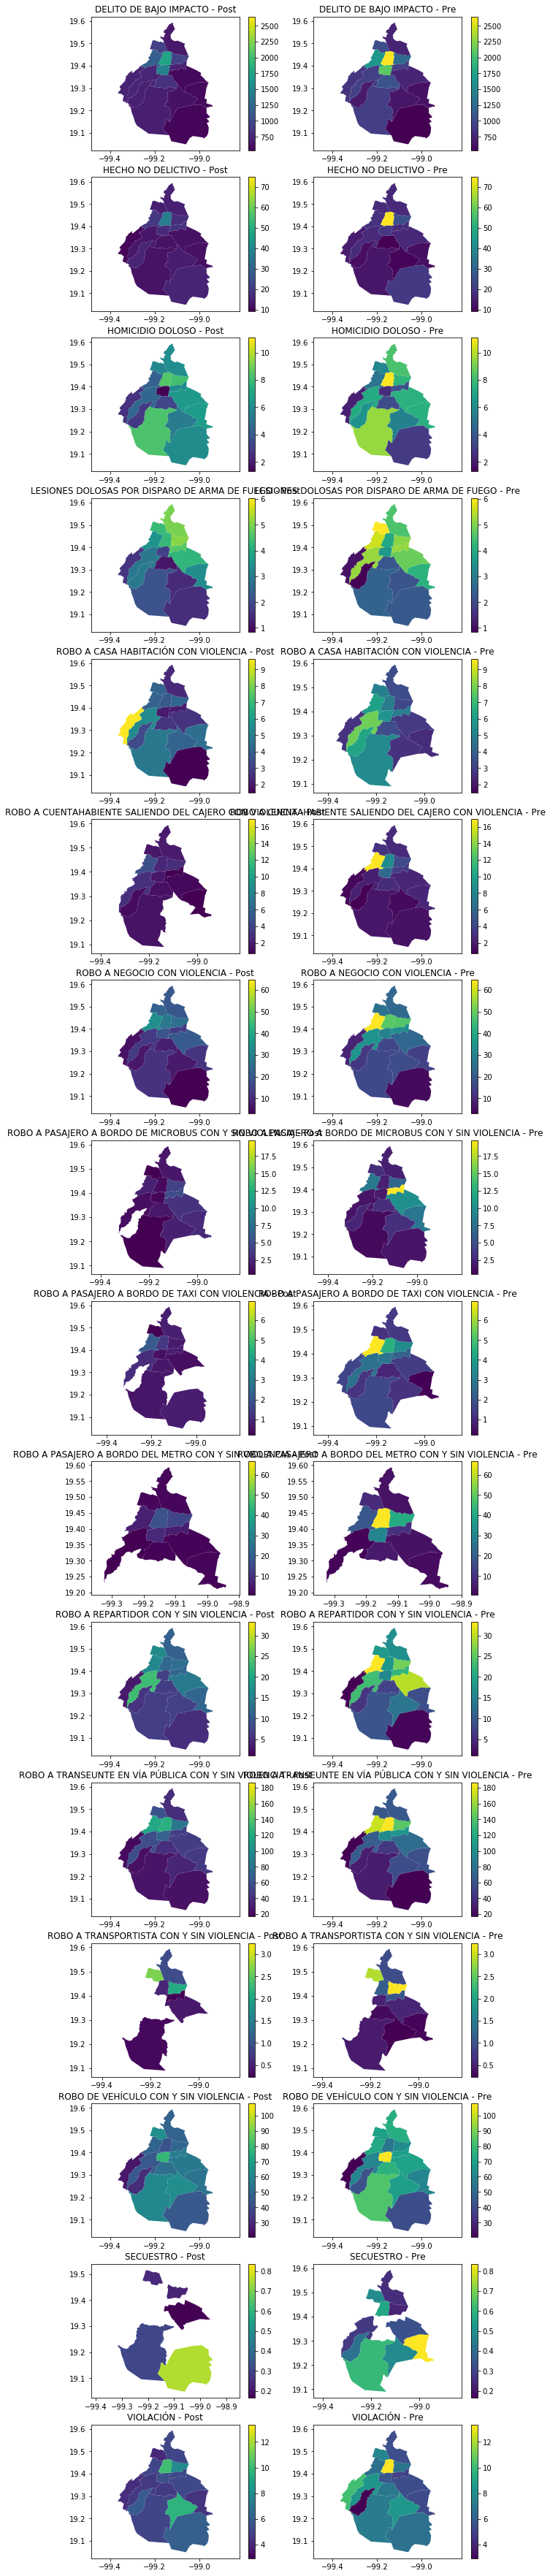

In [15]:
aux = mapa_del_plus\
    .sort_values('Periodo',ascending=False)\
    .groupby(['categoria_delito','Periodo'])

plt.figure(figsize=(10,64))

# itera por delitos y periodo
for i, ((aux_name,aux_per), aux_gdf) in enumerate(aux):

    ax = plt.subplot(16, 2, i + 1)
    
    aux_gdf.plot(ax=ax,column='tasa_delito',legend=True,
                 vmin=intervalos_delitos.loc[intervalos_delitos['categoria_delito']==aux_name,'min'],
                 vmax=intervalos_delitos.loc[intervalos_delitos['categoria_delito']==aux_name,'max'])

    ax.set_title(aux_name+' - '+aux_per)
    ax.set_aspect('equal', adjustable='datalim')

del aux

plt.show()

En los análisis subsecuentes, sólo trabajaremos con información de la "nueva normalidad"

In [16]:
datos_respaldo=datos.copy()

datos = datos[datos['Periodo']=='Post']

In [17]:
#datos_respaldo_2=datos.copy()
#datos=datos_respaldo.copy()

## Focos rojos

Por último, algo interesante sería ver, a nivel más desagregado, qué zonas son focos rojos actualmente.
Una hipótesis podría ser que las zonas de aglomeración de actividades no escenciales que fueron cerradas por la pandemia cayeron en su índice de incidencia delictiva sustancialmente, mientras que los robos a casa habitación con violencia o similares aumentaron.

Para esto, mostraremos la ubicación de cada crimen en la ciudad y buscaremos construir conjuntos de los mismos mediante BDSCAN, una técnica de aprendizaje no supervisado.

In [18]:
points = gpd.GeoDataFrame(datos[['longitud','latitud','categoria_delito','delito','Periodo']],
                          geometry=gpd.points_from_xy(datos['longitud'],
                                                      datos['latitud']))
points=points[points.is_valid]

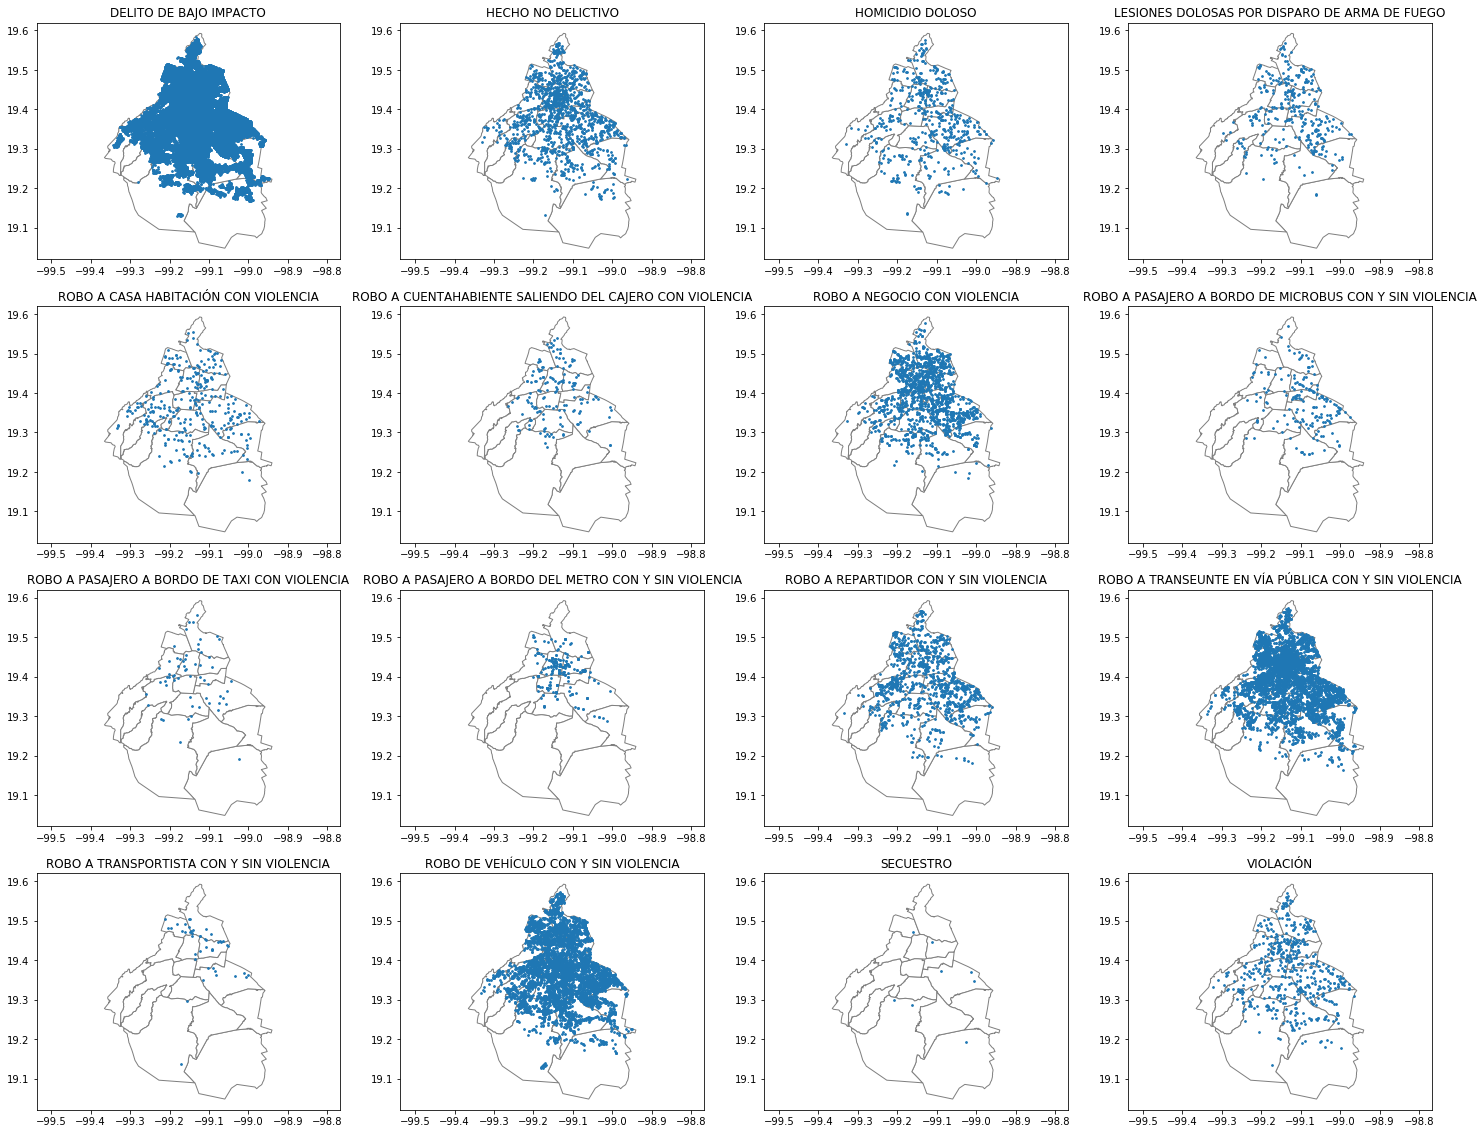

In [19]:
aux = points.groupby('categoria_delito')

plt.figure(figsize=(25,20))

for i, (aux_name, aux_gdf) in enumerate(aux):

    ax = plt.subplot(4, 4, i + 1) # nrows, ncols, axes position

    mapa_del.plot(ax=ax,color='white', edgecolor='grey')
    aux_gdf.plot(ax=ax,markersize=3)
    
    ax.set_title(aux_name)
    ax.set_aspect('equal', adjustable='datalim')

del aux

plt.show()

In [20]:
datos[['categoria_delito','delito']]\
    .groupby('categoria_delito').count().reset_index()

categoria_delito  delito
0                              DELITO DE BAJO IMPACTO   75138
1                                  HECHO NO DELICTIVO    1707
2                                    HOMICIDIO DOLOSO     561
3       LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO     489
4                ROBO A CASA HABITACIÓN CON VIOLENCIA     312
5   ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON ...     151
6                        ROBO A NEGOCIO CON VIOLENCIA    1539
7   ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN ...     189
8       ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA      64
9   ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VI...     307
10              ROBO A REPARTIDOR CON Y SIN VIOLENCIA    1081
11  ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...    4819
12           ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA      52
13               ROBO DE VEHÍCULO CON Y SIN VIOLENCIA    4767
14                                          SECUESTRO      11
15                                          VIOLACIÓN     631

Como se puede observar, hay muy pocos registros de secuestros y robos en taxi, por lo que omitiremos dichas categorías para el siguiente ejercicio, así como los delitos de bajo impacto y los hechos no delictivos.

In [21]:
#categorias_delitos=list(set(datos['categoria_delito']))

categorias_delitos=['ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA',
 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA',
 'ROBO A NEGOCIO CON VIOLENCIA',
 'ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA',
 'LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO',
 'VIOLACIÓN',
 'ROBO A REPARTIDOR CON Y SIN VIOLENCIA',
 'ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA',
 'ROBO DE VEHÍCULO CON Y SIN VIOLENCIA',
 'HOMICIDIO DOLOSO',
 'ROBO A CASA HABITACIÓN CON VIOLENCIA']

Para tener cierta perspectiva sobre las aglomeraciones, primero mostraremos un mapa de calor de población a nivel AGEB:

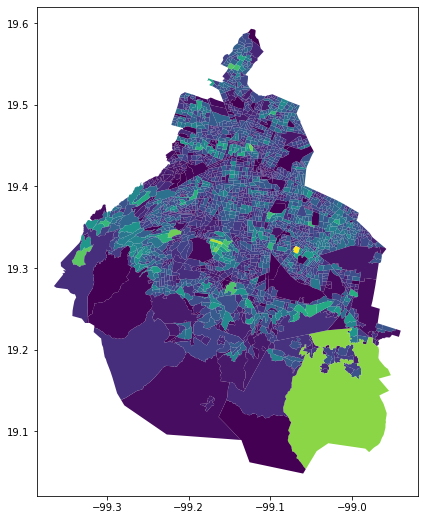

In [22]:
mapa.plot(column='POB_TOT',figsize=(11,9))

plt.show()

El algoritmo de BDSCAN toma como parámetros:
- La distancia máxima entre puntos para considerarlos dentro de un mismo cluster
- El número mínimo de observaciones dentro de un cluster para considerarlo un cluster

Para la distancia, tomamos 200 metros como la distancia adecuada para considerarlos dentro de una misma área. Para el número mínimo de observaciones, quizá con algunas objeciones válidas, se tomó el 2% del total de casos. 

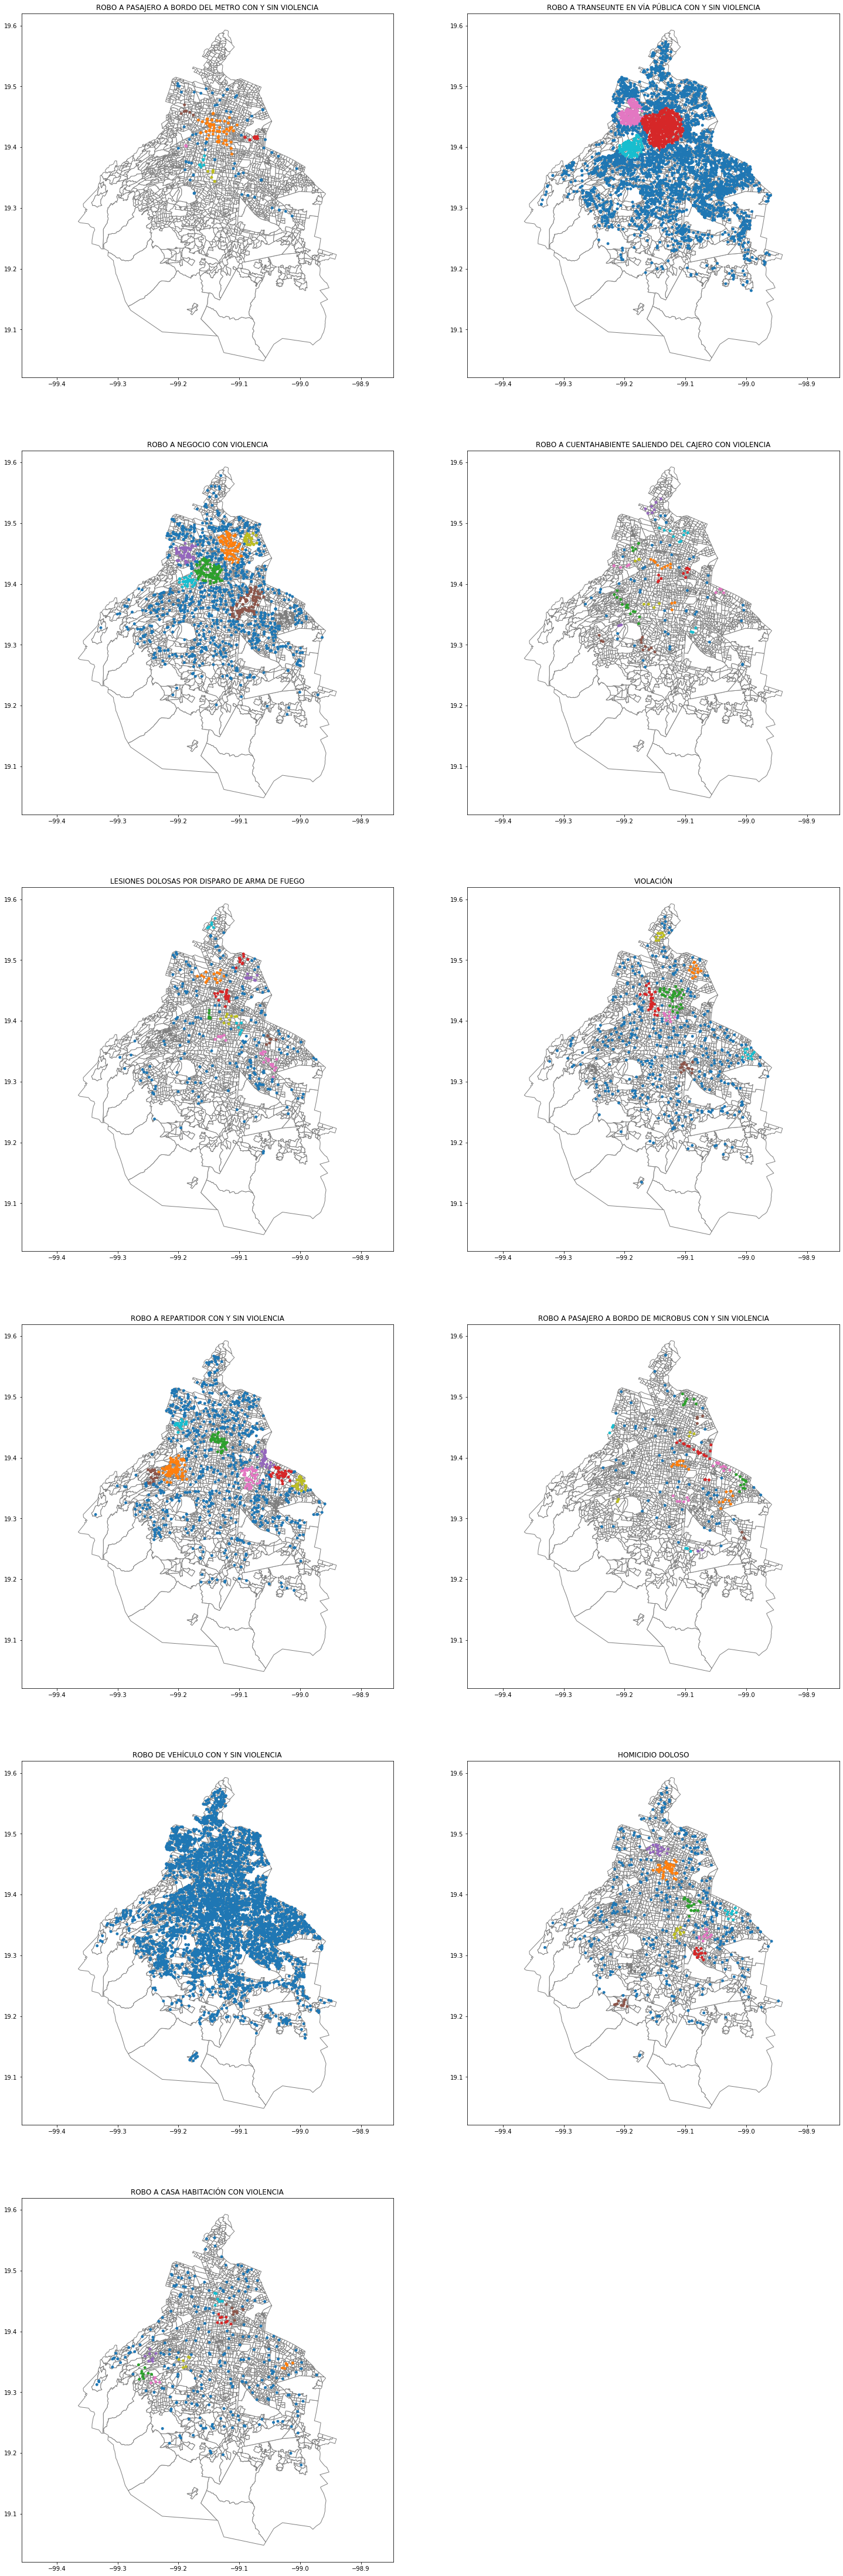

In [23]:

plt.figure(figsize=(25,80))

for i in range(len(categorias_delitos)):
    
    # generación de puntos
    points = gpd.GeoDataFrame(datos[(datos['Periodo']=='Post')&(datos['categoria_delito']==categorias_delitos[i])][['longitud','latitud','categoria_delito','delito']],
                          geometry=gpd.points_from_xy(datos.loc[(datos['Periodo']=='Post')&(datos['categoria_delito']==categorias_delitos[i]),'longitud'],
                                                      datos.loc[(datos['Periodo']=='Post')&(datos['categoria_delito']==categorias_delitos[i]),'latitud']))
    points=points[points.is_valid]
    
    # algoritmo de clasificación
    clustering = DBSCAN(eps=.0115,min_samples=np.round(points.shape[0]*.02)).fit(np.array(points[['longitud','latitud']]))

    ax = plt.subplot(6, 2, i + 1) # nrows, ncols, axes position

    mapa.plot(ax=ax,color='white', edgecolor='grey')
    points.plot(ax=ax,markersize=15,column=clustering.labels_,categorical=True)

    ax.set_title(categorias_delitos[i])
    ax.set_aspect('equal', adjustable='datalim')

#plt.tight_layout()
plt.show()

De esta visualización podemos sacar algunos comentarios:
- Por obvias razones los casos de robo en el metro ocurren en áreas muy específicas. En este caso el algoritmo muestra un gran cluster en el centro, probablemente por el simple hecho que hay muchas estaciones en dicha región.
- El robo a transeunte en vía pública muestra 3 conjuntos.
- Se observan concentraciones de violaciones en el centro, así como al norte y el este de la ciudad.
- Para robos en microbus el algoritmo no muestra conjuntos tan claros, pero esto no es tan necesario, dado que a simple vista se observa que las mayores concentraciones se observan en el este y en un corredor en la región noreste correspondiente a la calzada Ignacio Zaragoza.
- El robo de vehículo se encuentra bastante extendido a lo largo de la ciudad. Por ello, el algoritmo no muestra ningún punto de concentración en específico.
- Hay concentraciones de homicidios dolosos en el centro, el sur el norte y el este de la ciduad. En el centro podría explicarse por su densidad de población, mientras que la gran masa del este coincide con el hecho de que también tiene una alta densidad de población y que posee un nivel de marginación comparativamente mayor respecto al resto de la ciudad..
- Para robo a casa habitación se detectan puntos de concentración en 3 zonas: al centro, un pequeño conjunto al este y un conjunto más grande al oeste. Este último podría apuntar a zonas residenciales de la región, que es una zona de alta capacidad económica.